# Summary DL

In [0]:
#Importando librearias
import sys
import os
import json
import tempfile
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
sys.path.append('../')
sys.path.append('../../')
from sklearn.svm import SVC
from Resources.mlTracker import *
from Python.Style.styles import  *
from scipy.stats import expon, randint
from mlflow.tracking import MlflowClient

/databricks/python/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [0]:
#Desactivando wrnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
#Utilizando diseño base 1
plt.style.use('../../Python/Style/style1.mplstyle')

In [0]:
#Colores base
#Diseño base
mClr = designC['cs']
mClr_d2 = plt.get_cmap('cs-d')(2)
sClr1 = designC['nr']
sClr1_d2 = plt.get_cmap('nr-d')(2)
sClr3 = designC['az']
sClr2 = designC['gr']
sClr2_d = plt.get_cmap('gr-d')(0)
sClr2_d2 = plt.get_cmap('gr-d')(2)
sClr4 = designC['vr']
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 120

In [0]:
#Leyendo métricas de mlflow
client = MlflowClient()
experiment_id = client.get_experiment_by_name('/Users/victor.hugo.borrayo@gmail.com/DL_Results').experiment_id
runs = client.search_runs(experiment_id)
metrics = []
names = []
for run in runs:
    metrics.append(run.data.metrics)
    names.append(run.data.tags['mlflow.runName'])
df = pd.DataFrame(metrics)
columns = df.columns
df['name'] = names
columns = ['name'] + list(columns)
df = df[columns]

In [0]:
df

,name,Accuracy,F1 Score Macro,F1 Score Micro,F1 Score Weighted,False Negatives,False Positives,Precision,Recall,True Negatives,True Positives
0,DL-ANN-os_2_extra_t_mpca_thres Test2,0.779122,0.552844,0.779122,0.838556,16006.0,1336.0,0.977677,0.785206,2660.0,58512.0
1,DL-ANN-os_2_extra_t_mpca_thres Test1,0.792287,0.558341,0.792287,0.853915,10642.0,426.0,0.989591,0.791909,1718.0,40499.0
2,DL-ANN-os_2_extra_t_acc_thres Test2,0.937782,0.612958,0.937782,0.931437,1740.0,3145.0,0.958576,0.976650,851.0,72778.0
3,DL-ANN-os_2_extra_t_acc_thres Test1,0.954546,0.677533,0.954546,0.952359,1016.0,1406.0,0.972715,0.980133,738.0,50125.0
4,DL-ANN-os_2_extra_t_f1_thres Test2,0.926956,0.631250,0.926956,0.927852,2974.0,2761.0,0.962842,0.960090,1235.0,71544.0
...,...,...,...,...,...,...,...,...,...,...,...
91,DL-ANN-us_mpca_thres Test1,0.942535,0.522356,0.942535,0.934296,1041.0,2021.0,0.961225,0.979645,123.0,50100.0
92,DL-ANN-us_acc_thres Test2,0.051545,0.049147,0.051545,0.006255,74466.0,1.0,0.981132,0.000698,3995.0,52.0
93,DL-ANN-us_acc_thres Test1,0.040818,0.039308,0.040818,0.004277,51110.0,0.0,1.000000,0.000606,2144.0,31.0
94,DL-ANN-us_f1_thres Test2,0.512991,0.385080,0.512991,0.636988,36475.0,1762.0,0.955734,0.510521,2234.0,38043.0


In [0]:
#Extrayendo información
df["Test"] = df["name"].str.extract(r"(Test[\d])")
df["Experiment"] = df["name"].str.extract(r"(DL[\d]?)")
df["Threshold"] = df["name"].str.extract(r"([a-z1]+)_thres")
df["DatosEntrenamiento"] = df["name"].str.extract(r"ANN-([a-z]+)")
df["ANN"] = df["name"].str.extract(r"os_([\d])")
df["ANN"] = df["ANN"].fillna(1)
df["DeepLayers"] = df["ANN"].astype(int) + [1]*len(df)
df["Extra"] = df["name"].str.extract(r"extra_([a-z]+)")
mapper = {"us":"Undersampled","t":"Training"}
df["Extra"] = df["Extra"].map(mapper)
df["Extra"] = df["Extra"].fillna("-")
df["DatosEntrenamiento"] = df["DatosEntrenamiento"].apply(lambda x: "Oversampled" if x in ["os"] else "Undersampled")
df.drop(["ANN"], inplace = True, axis =1)
#Ordenando
df = df.sort_values(["Experiment","DatosEntrenamiento","Threshold","DeepLayers","Extra"])


In [0]:
df

,name,Accuracy,F1 Score Macro,F1 Score Micro,F1 Score Weighted,False Negatives,False Positives,Precision,Recall,True Negatives,True Positives,Test,Experiment,Threshold,DatosEntrenamiento,DeepLayers,Extra
86,DL-ANN-os_1_acc_thres Test2,0.798151,0.565044,0.798151,0.851052,14446.0,1402.0,0.977194,0.806141,2594.0,60072.0,Test2,DL,acc,Oversampled,2,-
87,DL-ANN-os_1_acc_thres Test1,0.806493,0.565874,0.806493,0.863066,9819.0,492.0,0.988234,0.808001,1652.0,41322.0,Test1,DL,acc,Oversampled,2,-
14,DL-ANN-os_1_extra_t_acc_thres Test2,0.940100,0.605318,0.940100,0.931817,1457.0,3246.0,0.957461,0.980448,750.0,73061.0,Test2,DL,acc,Oversampled,2,Training
15,DL-ANN-os_1_extra_t_acc_thres Test1,0.957680,0.678013,0.957680,0.953947,796.0,1459.0,0.971836,0.984435,685.0,50345.0,Test1,DL,acc,Oversampled,2,Training
20,DL-ANN-os_1_extra_us_acc_thres Test2,0.764794,0.544131,0.764794,0.829011,17182.0,1285.0,0.978080,0.769425,2711.0,57336.0,Test2,DL,acc,Oversampled,2,Undersampled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,DL4-ANN-us_acc_thres Test1,0.875612,0.645181,0.875612,0.908110,6342.0,286.0,0.993656,0.875990,1858.0,44799.0,Test1,DL4,acc,Undersampled,2,-
40,DL4-ANN-us_f1_thres Test2,0.846359,0.591425,0.846359,0.881311,10283.0,1780.0,0.973036,0.862006,2216.0,64235.0,Test2,DL4,f1,Undersampled,2,-
41,DL4-ANN-us_f1_thres Test1,0.871896,0.641130,0.871896,0.905748,6547.0,279.0,0.993782,0.871981,1865.0,44594.0,Test1,DL4,f1,Undersampled,2,-
36,DL4-ANN-us_mpca_thres Test2,0.846359,0.591425,0.846359,0.881311,10283.0,1780.0,0.973036,0.862006,2216.0,64235.0,Test2,DL4,mpca,Undersampled,2,-


In [0]:
#Agregando MPCA
def mpca(x):
    tp = x["True Positives"]
    tn = x["True Negatives"]
    fp = x["False Positives"]
    fn = x["False Negatives"]
    precission_0 = tn/(tn+fp)
    precission_1 = tp/(tp+fn)
    return (precission_0 + precission_1)/2
df["MPCA"] = df.apply(mpca,axis=1)
df.head()

,name,Accuracy,F1 Score Macro,F1 Score Micro,F1 Score Weighted,False Negatives,False Positives,Precision,Recall,True Negatives,True Positives,Test,Experiment,Threshold,DatosEntrenamiento,DeepLayers,Extra,MPCA
86,DL-ANN-os_1_acc_thres Test2,0.798151,0.565044,0.798151,0.851052,14446.0,1402.0,0.977194,0.806141,2594.0,60072.0,Test2,DL,acc,Oversampled,2,-,0.727645
87,DL-ANN-os_1_acc_thres Test1,0.806493,0.565874,0.806493,0.863066,9819.0,492.0,0.988234,0.808001,1652.0,41322.0,Test1,DL,acc,Oversampled,2,-,0.789262
14,DL-ANN-os_1_extra_t_acc_thres Test2,0.940100,0.605318,0.940100,0.931817,1457.0,3246.0,0.957461,0.980448,750.0,73061.0,Test2,DL,acc,Oversampled,2,Training,0.584068
15,DL-ANN-os_1_extra_t_acc_thres Test1,0.957680,0.678013,0.957680,0.953947,796.0,1459.0,0.971836,0.984435,685.0,50345.0,Test1,DL,acc,Oversampled,2,Training,0.651966
20,DL-ANN-os_1_extra_us_acc_thres Test2,0.764794,0.544131,0.764794,0.829011,17182.0,1285.0,0.978080,0.769425,2711.0,57336.0,Test2,DL,acc,Oversampled,2,Undersampled,0.723927


In [0]:
#Almacenando resultados
df.to_csv("results_dl.csv")
df.to_parquet("results_dl.parquet")

In [0]:
def plot_dataframe_as_table(df, columns_to_color=None, cmap='viridis', title="Tabla de resultados"):
    fig, ax = plt.subplots(figsize=(18, len(df)*0.3)) 
    ax.axis('tight')
    ax.axis('off')
    colormap = plt.get_cmap(cmap)
    #Aplicando escala de color
    cell_colors = []
    for i, row in df.iterrows():
        row_colors = []
        for col in df.columns:
            if columns_to_color and col in columns_to_color:
                norm = Normalize(vmin=df[col].min(), vmax=df[col].max())
                row_colors.append(colormap(norm(row[col])))
            else:
                row_colors.append((1, 1, 1, 1))
        cell_colors.append(row_colors)
    
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center', cellColours=cell_colors)
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)

    #Ajustando ancho columnas

    column_widths = {4: 0.09, 5: 0.09, 6: 0.09, 7:0.1}
    for (i, j), cell in table.get_celld().items():
        if j in column_widths:
            cell.set_width(column_widths[j])

    plt.title(title)
    plt.show()

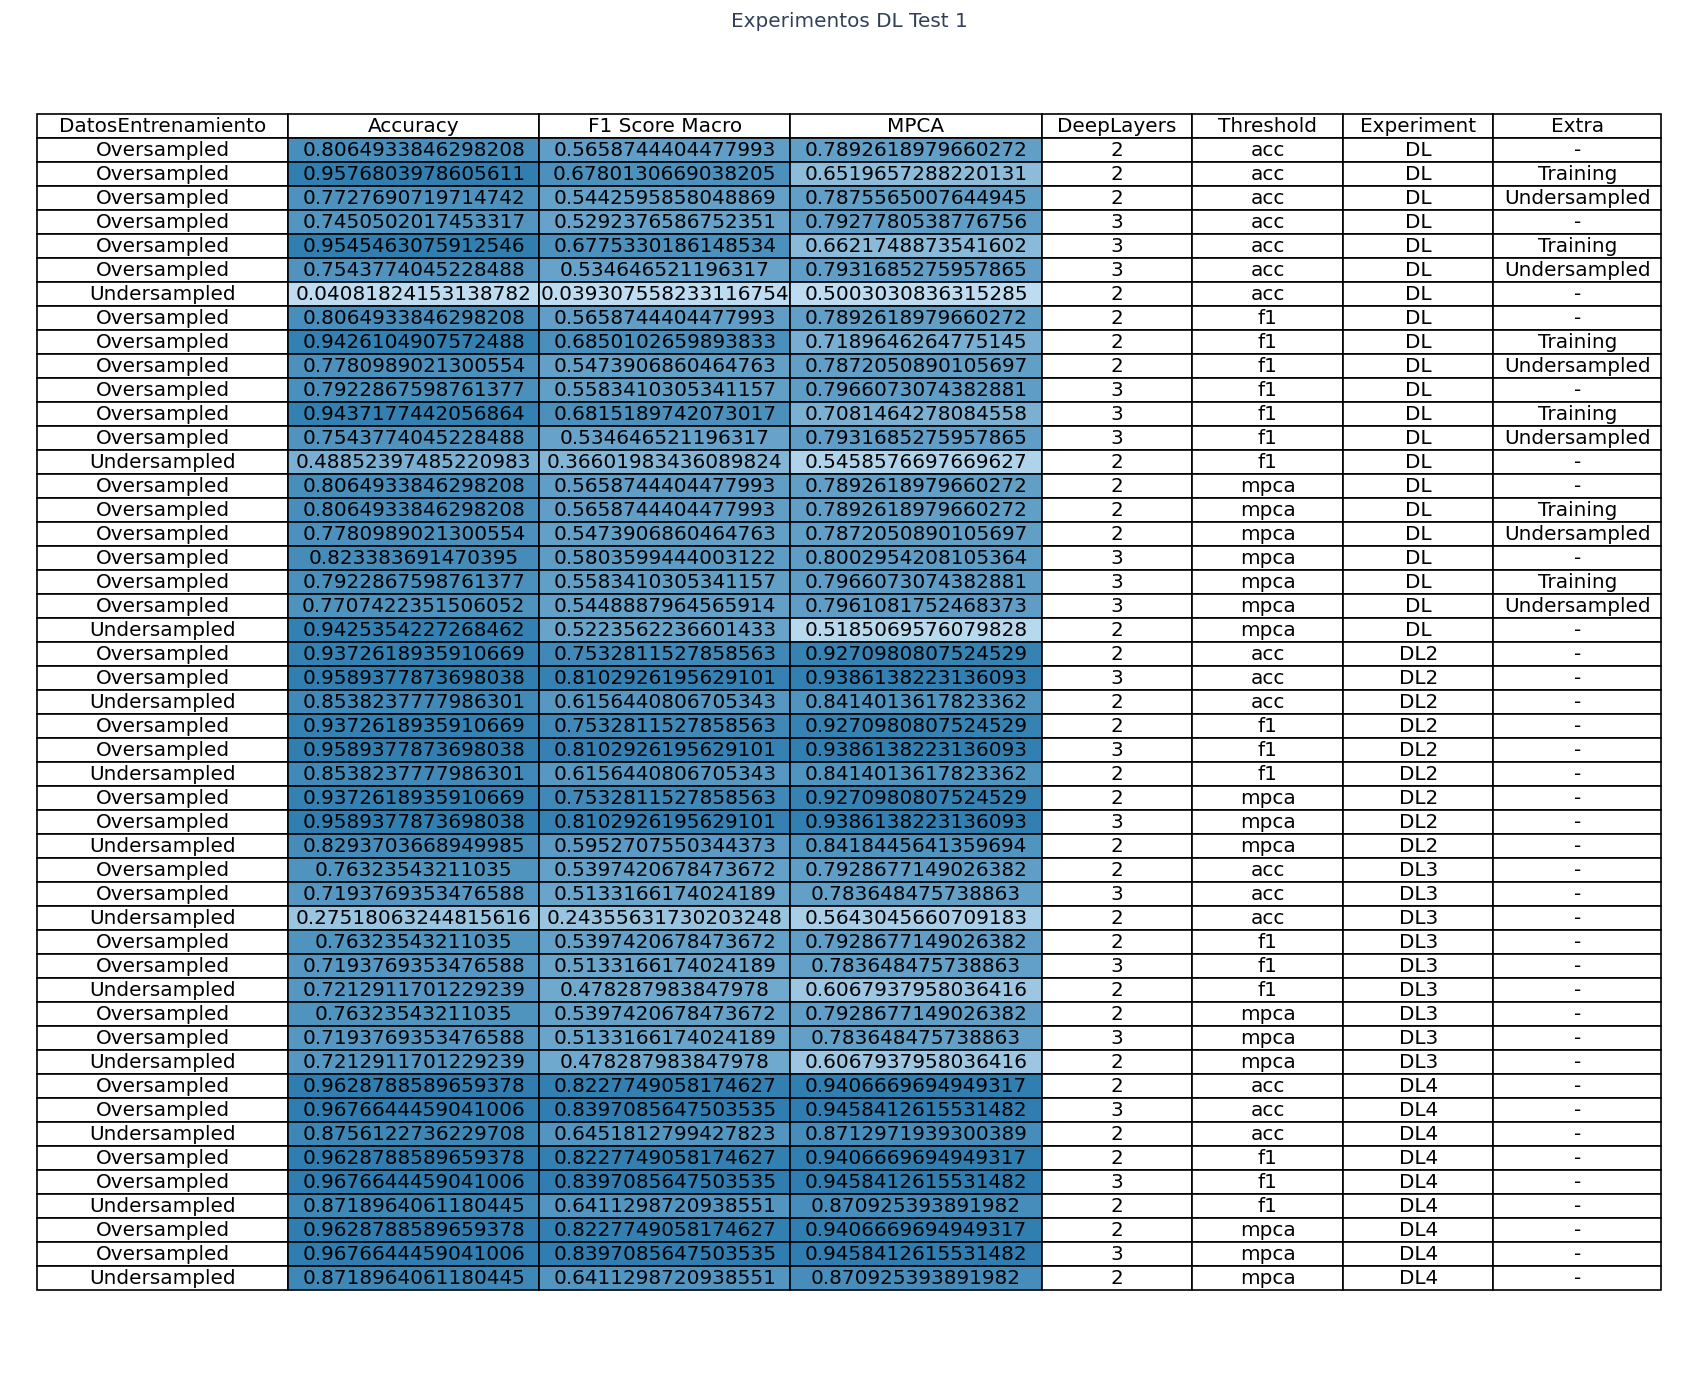

In [0]:
#Experimentos ML test 1
df_dl = df[df['Test'] == 'Test1']
df_dl = df_dl[["DatosEntrenamiento","Accuracy","F1 Score Macro","MPCA","DeepLayers","Threshold","Experiment","Extra"]]
df_dl = df_dl.sort_values(by=['Experiment','Threshold'])
plot_dataframe_as_table(df_dl, columns_to_color=['Accuracy', 'F1 Score Macro', 'MPCA'], cmap='cs-c', title='Experimentos DL Test 1')

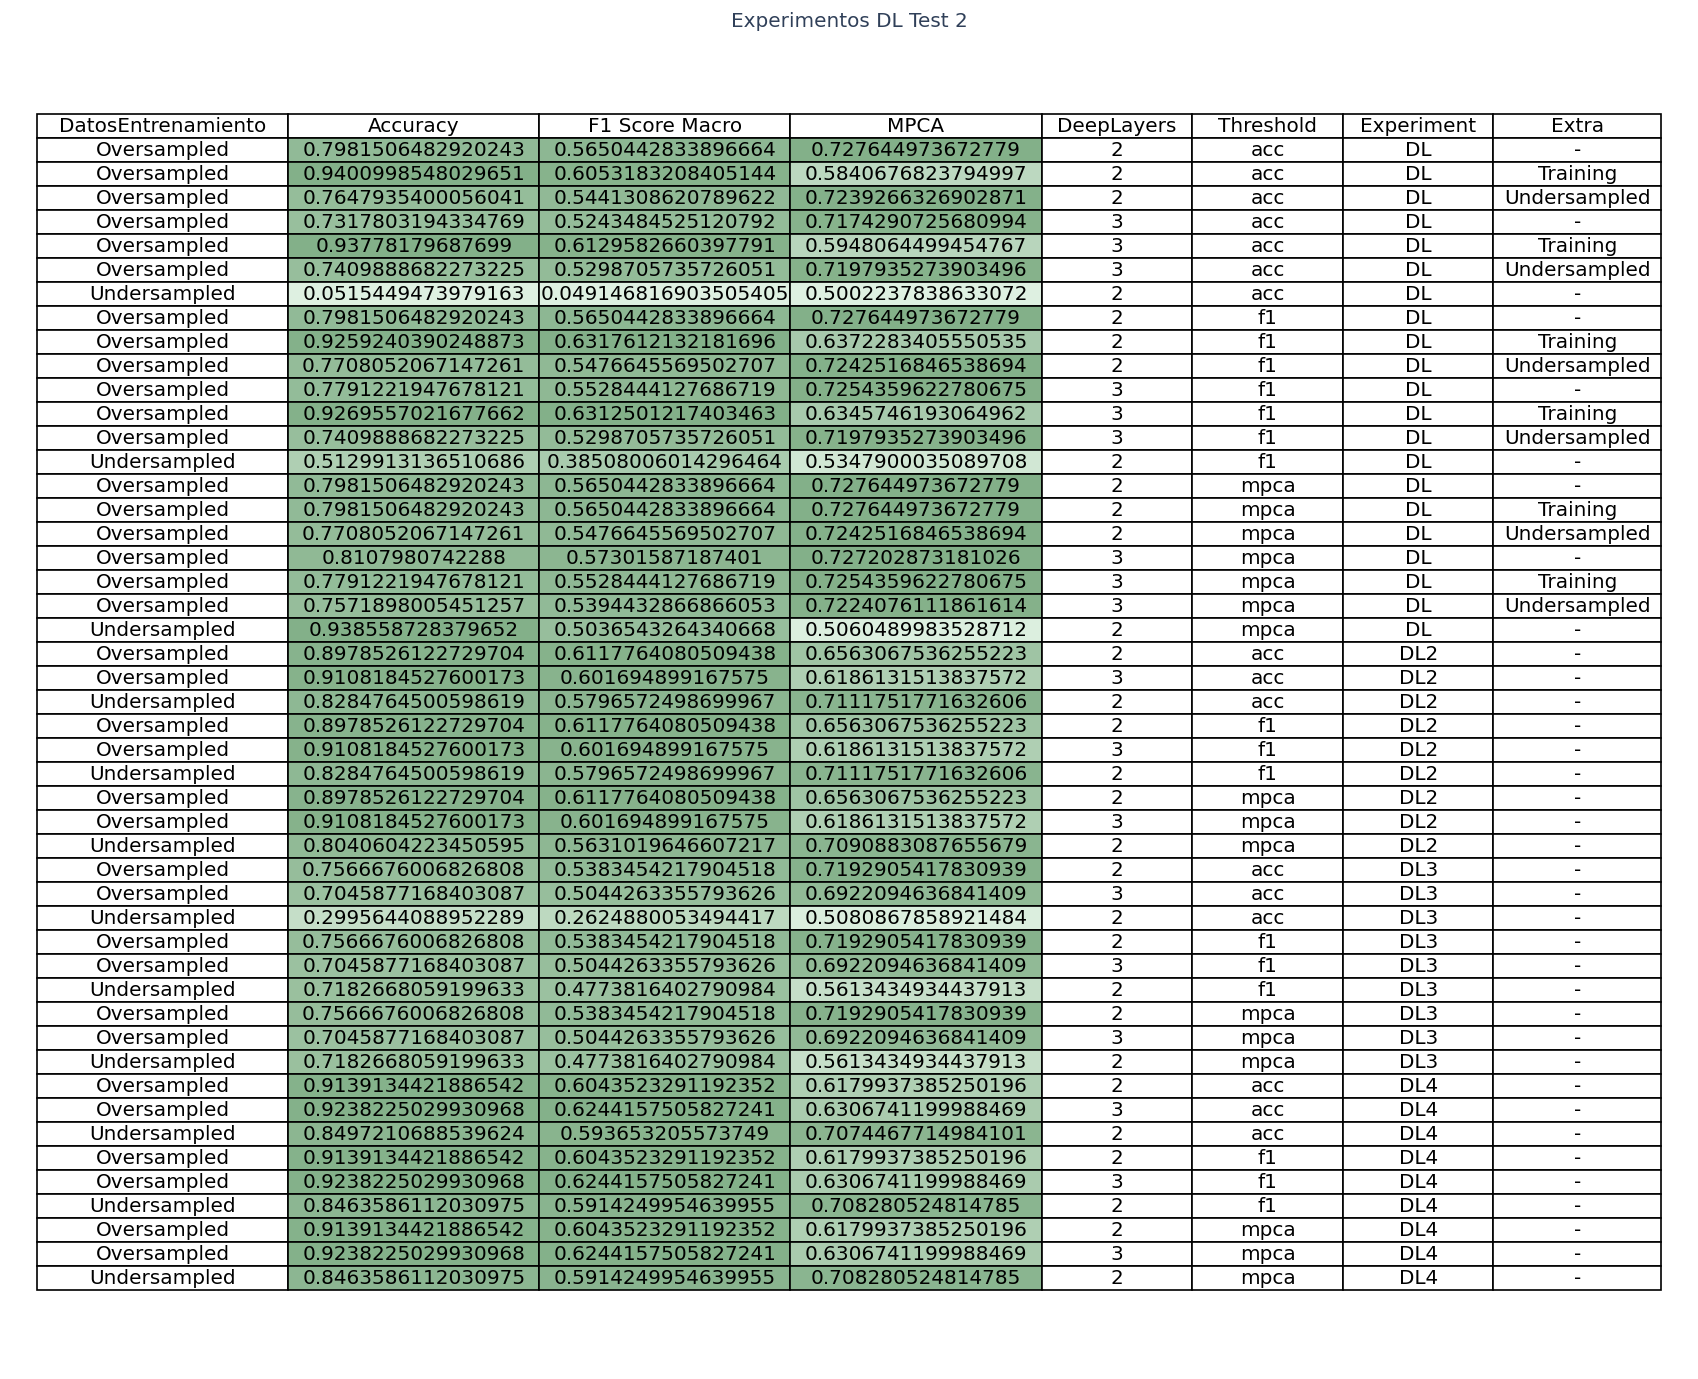

In [0]:
#Experimentos ML test 1
df_dl2 = df[df['Test'] == 'Test2']
df_dl2 = df_dl2[["DatosEntrenamiento","Accuracy","F1 Score Macro","MPCA","DeepLayers","Threshold","Experiment","Extra"]]
df_dl2 = df_dl2.sort_values(by=['Experiment','Threshold'])
plot_dataframe_as_table(df_dl2, columns_to_color=['Accuracy', 'F1 Score Macro', 'MPCA'], cmap='vr-c', title='Experimentos DL Test 2')

## Seleccionando modelos para problema 1

In [0]:
#Mejor modelo según Accuracy
df_dl_acc = df_dl[df_dl['Accuracy'] == df_dl['Accuracy'].max()]
df_dl_acc

,DatosEntrenamiento,Accuracy,F1 Score Macro,MPCA,DeepLayers,Threshold,Experiment,Extra
27,Oversampled,0.967664,0.839709,0.945841,3,acc,DL4,-
29,Oversampled,0.967664,0.839709,0.945841,3,f1,DL4,-
25,Oversampled,0.967664,0.839709,0.945841,3,mpca,DL4,-


In [0]:
#Mejor modelo según F1 Score Macro
df_dl_f1 = df_dl[df_dl['F1 Score Macro'] == df_dl['F1 Score Macro'].max()]
df_dl_f1

,DatosEntrenamiento,Accuracy,F1 Score Macro,MPCA,DeepLayers,Threshold,Experiment,Extra
27,Oversampled,0.967664,0.839709,0.945841,3,acc,DL4,-
29,Oversampled,0.967664,0.839709,0.945841,3,f1,DL4,-
25,Oversampled,0.967664,0.839709,0.945841,3,mpca,DL4,-


In [0]:
#Mejor modelo según F1 MPCA
df_dl_mpca = df_dl[df_dl['MPCA'] == df_dl['MPCA'].max()]
df_dl_mpca

,DatosEntrenamiento,Accuracy,F1 Score Macro,MPCA,DeepLayers,Threshold,Experiment,Extra
27,Oversampled,0.967664,0.839709,0.945841,3,acc,DL4,-
29,Oversampled,0.967664,0.839709,0.945841,3,f1,DL4,-
25,Oversampled,0.967664,0.839709,0.945841,3,mpca,DL4,-


## Seleccionando modelos para problema 2

In [0]:
#Mejor modelo según Accuracy
df_dl_acc_2 = df_dl2[df_dl2['Accuracy'] == df_dl2['Accuracy'].max()]
df_dl_acc_2

,DatosEntrenamiento,Accuracy,F1 Score Macro,MPCA,DeepLayers,Threshold,Experiment,Extra
14,Oversampled,0.9401,0.605318,0.584068,2,acc,DL,Training


In [0]:
#Mejor modelo según F1Score Macro
df_dl_f1_2 = df_dl2[df_dl2['F1 Score Macro'] == df_dl2['F1 Score Macro'].max()]
df_dl_f1_2

,DatosEntrenamiento,Accuracy,F1 Score Macro,MPCA,DeepLayers,Threshold,Experiment,Extra
16,Oversampled,0.925924,0.631761,0.637228,2,f1,DL,Training


In [0]:
#Mejor modelo según Accuracy MPCA
df_dl_mpca_2 = df_dl2[df_dl2['MPCA'] == df_dl2['MPCA'].max()]
df_dl_mpca_2

,DatosEntrenamiento,Accuracy,F1 Score Macro,MPCA,DeepLayers,Threshold,Experiment,Extra
86,Oversampled,0.798151,0.565044,0.727645,2,acc,DL,-
88,Oversampled,0.798151,0.565044,0.727645,2,f1,DL,-
84,Oversampled,0.798151,0.565044,0.727645,2,mpca,DL,-
12,Oversampled,0.798151,0.565044,0.727645,2,mpca,DL,Training
